In [1]:
import pygmt
import numpy as np
import pandas as pd
import re
import json
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors as colours
import os

In [2]:
def australia(fig=None, region=[112, 155, -46, -8], projection=None, **kwargs):
    ln_min, ln_max, lt_min, lt_max = region
    if projection is None:
        projection = f"M{int(np.mean([ln_min, ln_max]))}/{int(np.mean([lt_min, lt_max]))}/15c"
    if fig is None:
        fig = pygmt.Figure()
        fig.basemap(region=region, projection=projection, frame=True)

    fig.coast(
        region=region,
        projection=projection,
        shorelines=1,
        resolution="i",
        **kwargs
    )
    return fig, region, projection


In [4]:
with open(
    os.path.join("data","geological_timescale","timeline_data.json"),
    "r",
) as read_file:
    main = json.load(read_file)
    geological_timeline = {m["id"].split("/")[-1]: m for m in main}

with open(os.path.join("data","geological_timescale","time_interval_data.json"), "r") as read_file:
    intervals = json.load(read_file)
    
for K, V in geological_timeline.items():
    for k, v in intervals.items():
        if k.split("/")[-1] == K:
            V |= v
            break
for K, V in geological_timeline.items():
    del V["name"]
    for k, v in V.items():
        if k == "narrow":
            V["children"] = [n.split("/")[-1] for n in v]
            del V[k]
        elif k == "broad":
            V["parent"] = [b.split("/")[-1] for b in v]
            del V[k]
            break

In [5]:
eras = {k: v for k, v in geological_timeline.items() if k in ["Cenozoic", "Mesozoic", "Paleozoic"]}
periods = {}
for k, v in geological_timeline.items():
    if v["type"] == "period":
        if v["parent"][0] in eras.keys():
            periods[k] = v
        
# cmap = cm.get_cmap("Spectral", len(periods))
# for i, p in enumerate(periods):
#     periods[p]["fill"] = colours.to_hex(cmap(i))

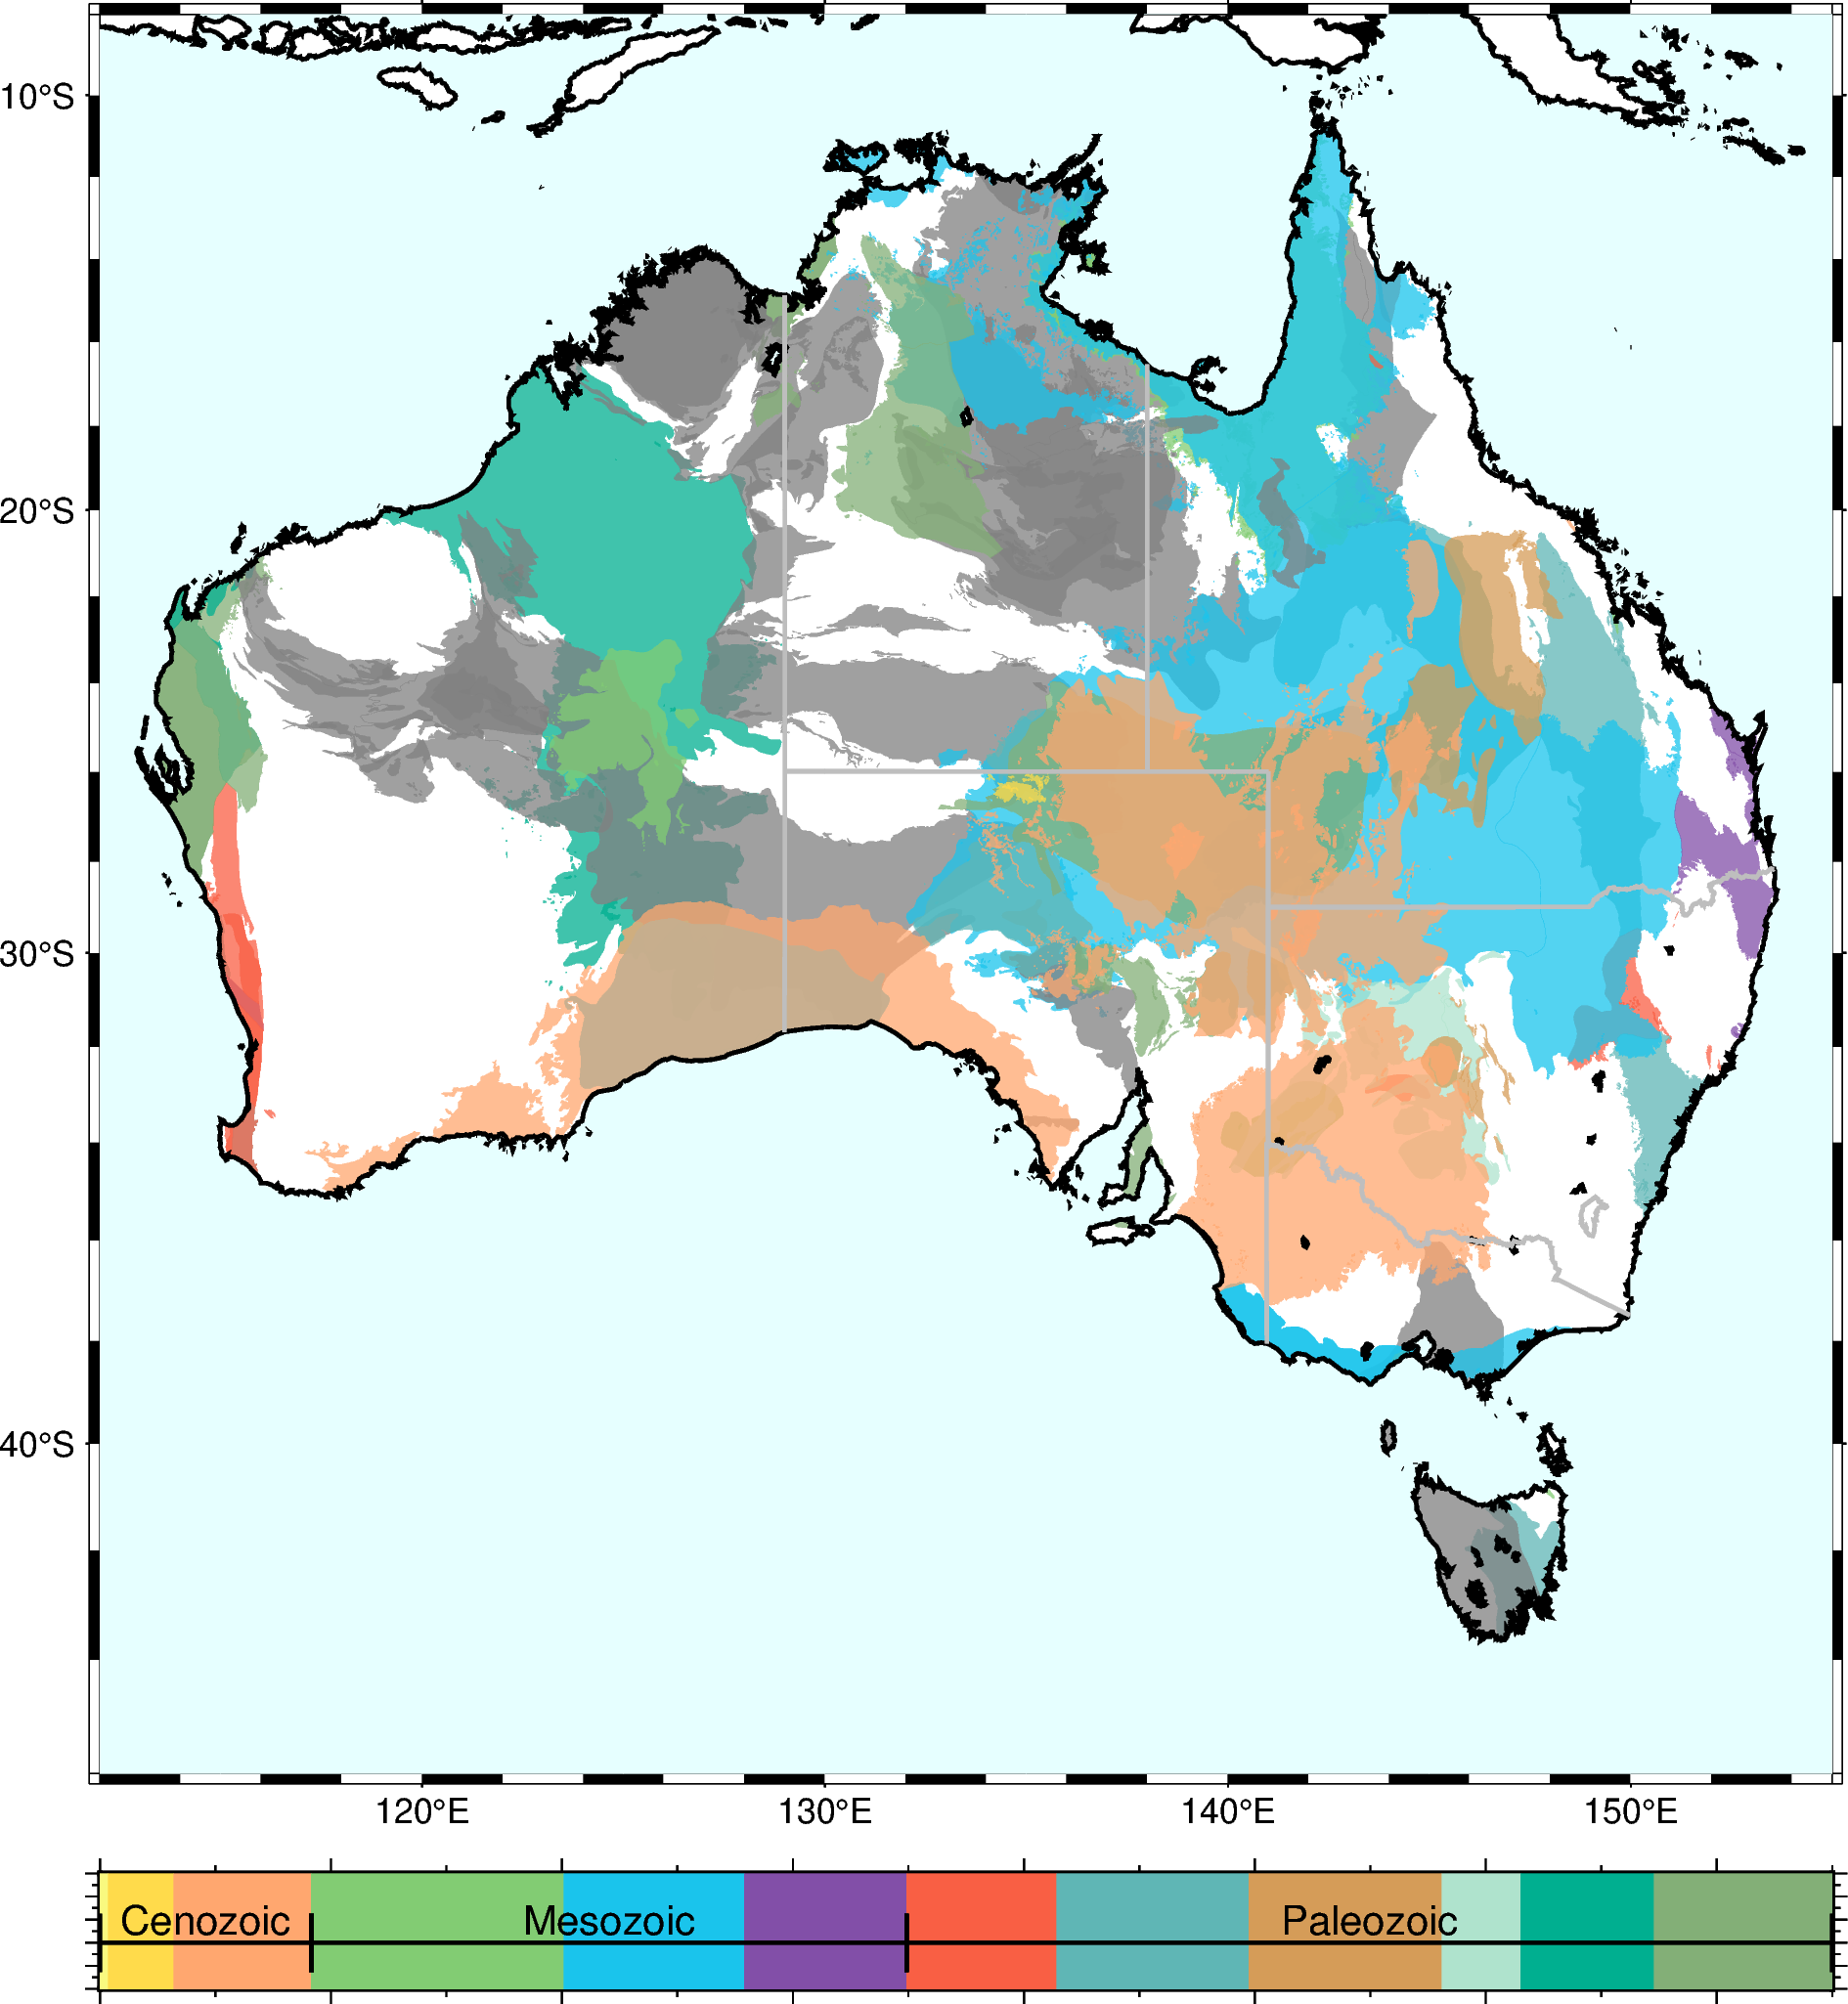

In [6]:
fig = pygmt.Figure()
fig_width = 15
with fig.subplot(nrows=2, ncols=1, figsize=(f"{fig_width}c", f"3c")):
    # with fig.set_panel(panel=0):
    with fig.set_panel(0):
        region=[112, 155, -46, -8]
        ln_min, ln_max, lt_min, lt_max = region
        projection = f"M{int(np.mean([ln_min, ln_max]))}/{int(np.mean([lt_min, lt_max]))}/{fig_width}c"
        fig.basemap(region=region, projection=projection, frame=True)
        polygons = pd.read_csv(os.path.join("data", "australian_sedimentary_basins", "all.csv"))
        polygons["Shape"] = polygons["Shape"].map(lambda x: x.strip("MULTIPOLYGON"))
        polygons.drop(polygons[polygons.onoffshore == "Off"].index, inplace=True)
        for i, polygon in polygons[::-1].iterrows():  # [::-1] flips the df to plot the oldest first
            shapes = re.findall('\([^)]*\)', polygon["Shape"])
            for shape in shapes:
                name = polygon["oldnameage"]
                if not isinstance(name, str):
                    continue
                for p in name.split():
                    if p in geological_timeline:
                        _p = p
                        _type = geological_timeline[_p]["type"]
                        going_up = True
                        while _type != "period":
                            if going_up:
                                try:
                                    _p = geological_timeline[_p]["parent"][0]
                                except IndexError: # no more parents
                                    going_up = False
                            else:
                                try:
                                    _p = geological_timeline[_p]["children"][-1]  # oldest child
                                except IndexError as e: # no more children
                                    raise e(f"No period found for {p}")
                            _type = geological_timeline[_p]["type"]
                        try:
                            fill = periods[_p]['fill']
                        except KeyError: # precambrian
                            fill = "#80808080"
                        break
                shape = shape.strip("()").split(",")
                lonlat = pd.Series(shape).str.split(expand=True).astype(float)
                fig.plot(x=lonlat[0], y=lonlat[1], region=region, projection=projection, fill=fill, transparency=25)
        fig.coast(
            region=region,
            projection=projection,
            shorelines=1,
            resolution="i",
            water="#e6ffff",
            borders="2/1p,grey",
        )
    
    with fig.set_panel(1):
        region = [0, fig_width, 0, 1]
        projection = f"X{fig_width}c/1c"
        fig.basemap(region=region, projection=projection, frame=["wsne"])
        max_age = max([v["hasBeginning"] for v in periods.values()])

        def _scale_age_to_bar_length(age):
            return age / max_age * fig_width

        for i, p in enumerate(periods.values()):
            # fill = colours.to_hex(cmap(i))
            fill = p["fill"]
            beginning = _scale_age_to_bar_length(p["hasBeginning"])
            end = _scale_age_to_bar_length(p["hasEnd"])
            fig.plot(x=beginning, y=0.5, style=f"B1c+b{end}", fill=fill, region=region, projection=projection)

        font = "10p,Helvetica"
        for k, e in eras.items():
            beginning = _scale_age_to_bar_length(e["hasBeginning"])
            end = _scale_age_to_bar_length(e["hasEnd"])
            mid = (end + beginning) / 2
            length = beginning - end
            angle = 0
            fig.plot(x=end, y=0.4, style="v0.3c+bt+et+a80", direction=([angle], [length]), pen="1p", region=region, projection=projection)
            fig.text(x=mid, y=0.6, font=font, text=k, region=region, projection=projection)

fig.show()